<a href="https://colab.research.google.com/github/janakg/era-s5/blob/main/S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [2]:
# import os

# # Define the repository and the target directory
# repo_url = 'https://github.com/janakg/era-s9.git'
# target_dir = '/content/era-s9'

# # Check if the directory already exists
# if not os.path.exists(target_dir):
#     # If it doesn't exist, clone the repo
#     !git clone {repo_url}
# else:
#     # If it exists, 'cd' into the directory and pull the latest changes
#     %cd {target_dir}
#     !git pull

# # Add the repository's directory to the system path
# import sys
# sys.path.append(target_dir)

# Import all utils functions
from utils import *

In [3]:
# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)


# For reproducibility. SEED Random functions
SEED = 1
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True


In [4]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transforms = A.Compose([
    A.RandomCrop(32, 32, p=1.0),
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.9),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, 
                    min_height=16, min_width=16, fill_value=mean, mask_fill_value=None),
    A.Normalize(mean, std),
    ToTensorV2()
])

class AlbumentationsCIFAR10Wrapper(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None):
        self.data = datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = np.array(img)  # PIL Image to numpy array
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        return img, label

    def __len__(self):
        return len(self.data)

In [5]:
# Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomRotation(15),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [6]:
train_data = AlbumentationsCIFAR10Wrapper(root='./data', train=True, 
                                          download=True, transform=train_transforms)

test_data = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


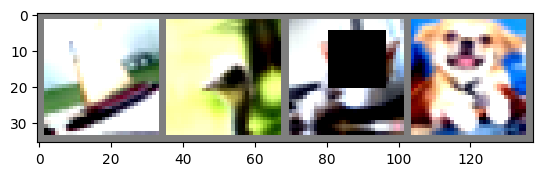

ship  bird  cat   dog  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# # Call the util function to show a batch of images
# import matplotlib.pyplot as plt
# fig = plt.figure()
# show_batch_images(plt, train_loader, 12, 3, 4)

In [9]:
# model imported from a module
from model import Net

In [10]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]          18,432
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
             ReLU-14           [-1, 32,

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_succeeded, train_processed, train_loss = train(model, device, train_loader, optimizer, criterion)
  train_acc.append(100 * train_succeeded/train_processed)
  train_losses.append(train_loss / len(train_loader))

  test_succeeded, test_loss = test(model, device, test_loader, criterion)
  test_acc.append(100. * test_succeeded / len(test_loader.dataset))
  test_losses.append(test_loss)

  # scheduler.step()

Epoch 1


Train: Loss=1.5930 Batch_id=97 Accuracy=32.45: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 1.9527, Accuracy: 3609/10000 (36.09%)

Epoch 2


Train: Loss=1.5173 Batch_id=97 Accuracy=44.70: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 1.5318, Accuracy: 4611/10000 (46.11%)

Epoch 3


Train: Loss=1.3650 Batch_id=97 Accuracy=49.29: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Test set: Average loss: 1.4627, Accuracy: 4876/10000 (48.76%)

Epoch 4


Train: Loss=1.2587 Batch_id=97 Accuracy=52.32: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 1.3766, Accuracy: 5283/10000 (52.83%)

Epoch 5


Train: Loss=1.1949 Batch_id=97 Accuracy=55.28: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 1.4541, Accuracy: 5277/10000 (52.77%)

Epoch 6


Train: Loss=1.1785 Batch_id=97 Accuracy=57.21: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Test set: Average loss: 1.2777, Accuracy: 5559/10000 (55.59%)

Epoch 7


Train: Loss=1.0783 Batch_id=97 Accuracy=58.90: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 1.1066, Accuracy: 6144/10000 (61.44%)

Epoch 8


Train: Loss=1.1694 Batch_id=97 Accuracy=60.17: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 1.1196, Accuracy: 6071/10000 (60.71%)

Epoch 9


Train: Loss=1.0624 Batch_id=97 Accuracy=61.27: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 1.1211, Accuracy: 6139/10000 (61.39%)

Epoch 10


Train: Loss=1.0298 Batch_id=97 Accuracy=62.49: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.9355, Accuracy: 6739/10000 (67.39%)

Epoch 11


Train: Loss=1.0473 Batch_id=97 Accuracy=63.72: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Test set: Average loss: 0.9199, Accuracy: 6756/10000 (67.56%)

Epoch 12


Train: Loss=1.0347 Batch_id=97 Accuracy=64.66: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Test set: Average loss: 0.9092, Accuracy: 6833/10000 (68.33%)

Epoch 13


Train: Loss=0.9179 Batch_id=97 Accuracy=65.77: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Test set: Average loss: 0.9489, Accuracy: 6737/10000 (67.37%)

Epoch 14


Train: Loss=1.0323 Batch_id=97 Accuracy=66.38: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.8950, Accuracy: 6924/10000 (69.24%)

Epoch 15


Train: Loss=0.9285 Batch_id=97 Accuracy=66.99: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.8805, Accuracy: 6966/10000 (69.66%)

Epoch 16


Train: Loss=0.8411 Batch_id=97 Accuracy=67.81: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.8365, Accuracy: 7174/10000 (71.74%)

Epoch 17


Train: Loss=0.8930 Batch_id=97 Accuracy=68.47: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.8126, Accuracy: 7250/10000 (72.50%)

Epoch 18


Train: Loss=0.9092 Batch_id=97 Accuracy=68.96: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.8271, Accuracy: 7139/10000 (71.39%)

Epoch 19


Train: Loss=0.8602 Batch_id=97 Accuracy=69.63: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Test set: Average loss: 0.7432, Accuracy: 7375/10000 (73.75%)

Epoch 20


Train: Loss=0.8662 Batch_id=97 Accuracy=69.96: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.8175, Accuracy: 7228/10000 (72.28%)



In [13]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.03, inplace=False)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03, inpla

In [14]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 13
conv_layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


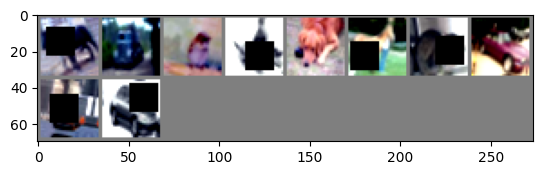

In [15]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


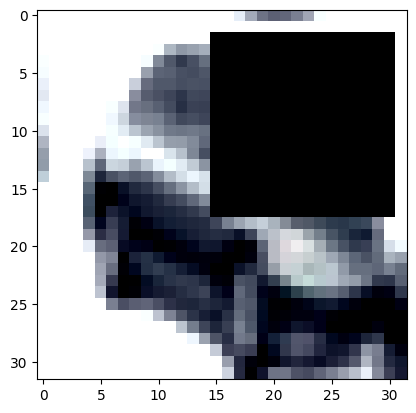

In [16]:
image = images[9]
imshow(image)

In [17]:
image = image.unsqueeze(0)
image = image.to(device)

In [18]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

13
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 10, 32, 32])


In [19]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


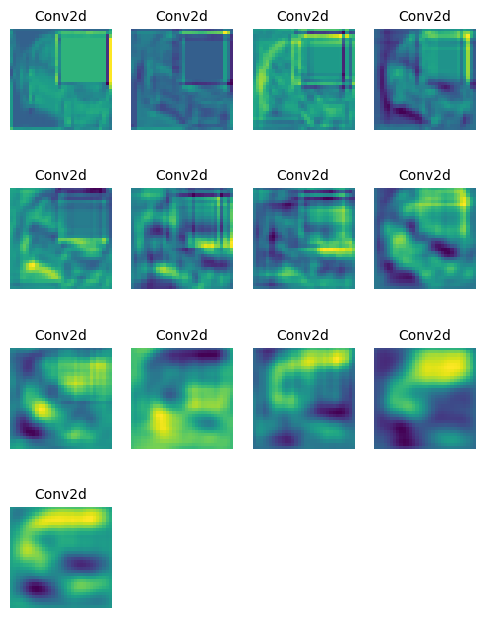

In [20]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

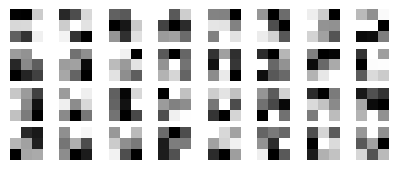

In [21]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()